<h1>Self-RAG</h1>

<h2>Setup</h2>

In [107]:
from dotenv import load_dotenv

load_dotenv()

True

In [108]:
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_core.messages import AIMessage, HumanMessage, ToolMessage

llm = ChatOpenAI(model="gpt-4o", temperature=0)
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

In [109]:
# Test
response = llm.invoke("Hi")
response

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 8, 'total_tokens': 18, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_eb9dce56a8', 'finish_reason': 'stop', 'logprobs': None}, id='run-e9e64828-6cc5-47e4-b82a-989a5eef2a9c-0', usage_metadata={'input_tokens': 8, 'output_tokens': 10, 'total_tokens': 18, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

<h2>Retriever</h2>

In [110]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma

urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

docs = [WebBaseLoader(url).load() for url in urls] #Load documents
docs_list = [item for sublist in docs for item in sublist] #Flatten the list

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, chunk_overlap=0
)
doc_splits = text_splitter.split_documents(docs_list)

# Add to vectorDB
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=embeddings,
)
retriever = vectorstore.as_retriever()

In [111]:
# Test
question = "agent memory"
documents = retriever.invoke(question) #the default number of retrieved documents (k) is 4, return a list of documents
type(documents)

list

In [112]:
type(documents[0])

langchain_core.documents.base.Document

In [113]:
documents[0].page_content

'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview#\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.\n\n\nMemory'

<h2>Documents Grader</h2>

In [114]:
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field

# Data model
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: int = Field(
        description="Documents are relevant to the question, 0 or 1"
    )

# LLM with function call
structured_llm_grader = llm.with_structured_output(GradeDocuments)

# Prompt
system = """
You are a grader assessing relevance of a retrieved document to a user question. 
It does not need to be a stringent test. The goal is to filter out erroneous retrievals. 
If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant.
Give a binary score 0 or 1 score to indicate whether the document is relevant to the question."""

human_msg = """
    Retrieved documents: 
    {documents} 
    
    User question: 
    {question}""" 

grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", human_msg),
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader

In [115]:
grade_prompt.pretty_print() 

================================ System Message ================================


You are a grader assessing relevance of a retrieved document to a user question. 
It does not need to be a stringent test. The goal is to filter out erroneous retrievals. 
If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant.
Give a binary score 0 or 1 score to indicate whether the document is relevant to the question.

================================ Human Message =================================


    Retrieved documents: 
    {documents} 
    
    User question: 
    {question}


In [116]:
# Test
score = retrieval_grader.invoke({"question": question, "documents": documents}) #We can pass a list of documents, a single document or a string
type(score)

__main__.GradeDocuments

In [117]:
score.binary_score

1

<h2>Generate Answer</h2>

In [118]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser

# Prompt
prompt = hub.pull("rlm/rag-prompt") #prompt has context and question parameter

# Chain
rag_chain = prompt | llm | StrOutputParser()

In [119]:
prompt.pretty_print() 

================================ Human Message =================================

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:


In [120]:
# Test
generation = rag_chain.invoke({"context": documents, "question": question})
print(generation)

In an LLM-powered autonomous agent system, memory is divided into short-term and long-term components. Short-term memory involves in-context learning, while long-term memory allows the agent to retain and recall information over extended periods, often using an external vector store for fast retrieval. This memory system enables the agent to learn from past actions and improve future performance.


<h2>Hallucination Grader</h2>

In [121]:
# Data model
class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""

    binary_score: int = Field(
        description="Answer is grounded in the facts, 0 or 1"
    )


# LLM with function call
structured_llm_grader = llm.with_structured_output(GradeHallucinations)

# Prompt
system = """
You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts.
Give a binary score 1 or 0. 1 means that the answer is grounded in / supported by the set of facts."""

human_msg = """
    Set of facts: 
    {documents} 
    
    LLM generation: 
    {generation}"""
    
hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", human_msg),
    ]
)

hallucination_grader = hallucination_prompt | structured_llm_grader

In [122]:
grade_prompt.pretty_print() 

================================ System Message ================================


You are a grader assessing relevance of a retrieved document to a user question. 
It does not need to be a stringent test. The goal is to filter out erroneous retrievals. 
If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant.
Give a binary score 0 or 1 score to indicate whether the document is relevant to the question.

================================ Human Message =================================


    Retrieved documents: 
    {documents} 
    
    User question: 
    {question}


In [123]:
# Test
score = hallucination_grader.invoke({"documents": documents, "generation": generation})
type(score)

__main__.GradeHallucinations

In [124]:
score.binary_score

1

<h2>Answer Grader</h2>

In [125]:
# Data model
class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses question."""

    binary_score: int = Field(
        description="Answer addresses the question, 1 or 0"
    )


# LLM with function call
structured_llm_grader = llm.with_structured_output(GradeAnswer)

# Prompt
system = """
You are a grader assessing whether an answer addresses / resolves a question.
Give a binary score 1 or 0. 1 means that the answer resolves the question."""

human_msg = """
    User question:
    {question} 
    
    LLM generation:
    {generation}""" 

answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", human_msg),
    ]
)

answer_grader = answer_prompt | structured_llm_grader

In [126]:
# Test 
score = answer_grader.invoke({"question": question, "generation": generation})
type(score)

__main__.GradeAnswer

In [127]:
score.binary_score

0

<h2>Question Re-writer</h2>

In [128]:

# Prompt
system = """
You a question re-writer that converts an input question to a better version that is optimized for web search. 
Look at the input and try to reason about the underlying semantic intent / meaning."""

human_msg = """
    Look at the input and try to reason about the underlying semantic intent / meaning.
    
    Here is the initial question: 
    {question}
    
    Formulate an improved question.""" 

re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", human_msg)
    ]
)

question_rewriter = re_write_prompt | llm | StrOutputParser()

In [129]:
re_write_prompt.pretty_print()

================================ System Message ================================


You a question re-writer that converts an input question to a better version that is optimized for web search. 
Look at the input and try to reason about the underlying semantic intent / meaning.

================================ Human Message =================================


    Look at the input and try to reason about the underlying semantic intent / meaning.
    
    Here is the initial question: 
    {question}
    
    Formulate an improved question.


In [130]:
# Test
better_question = question_rewriter.invoke({"question": question})
print(better_question)

What is agent memory and how does it function in artificial intelligence systems?


<h2>Graph State</h2>

In [131]:
from typing import List
from typing_extensions import TypedDict
from langchain.schema import Document

class State(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """
    question: str
    generation: str
    documents: List[Document]

<h2>Retriever Node</h2>

In [132]:
def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    
    return {"documents": documents}

<h2>Documents Grader Node</h2>

If any docs are relevant, we can proceed with generating answer

In [133]:
def grade(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    for doc in documents:
        score = retrieval_grader.invoke(
            {"question": question, "documents": doc}
        )
        grade = score.binary_score 
        if grade == 1:
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(doc)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            
    return {"documents": filtered_docs}

<h2>Generate Node</h2>

In [134]:
def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    
    return {"generation": generation}

<h2>Question Re-writer Node</h2>

In [135]:
def rewrite(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("---Rewrite---")
    question = state["question"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    
    return {"question": better_question}

<h2>Conditional Edge</h2>

In [136]:
from typing import Literal

def decide_to_generate(state) -> Literal["generate", "rewrite"]:
    """
    Determines whether to generate an answer, or rewrite a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    filtered_documents = state["documents"]

    if not filtered_documents:
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, REWRITE QUESTION---"
        )
        return "rewrite"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"

In [137]:
def decide_to_answer(state) -> Literal["useful", "not useful", "not supported"]:
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    hallucination_score = hallucination_grader.invoke(
        {"documents": documents, "generation": generation}
    )
    hallucination_grade = hallucination_score.binary_score

    # Check hallucination
    if hallucination_grade == 1:
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        answer_score = answer_grader.invoke({"question": question, "generation": generation})
        answer_grade = answer_score.binary_score
        if answer_grade == 1:
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        else:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
    else:
        print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"

<h2>Build Graph</h2>

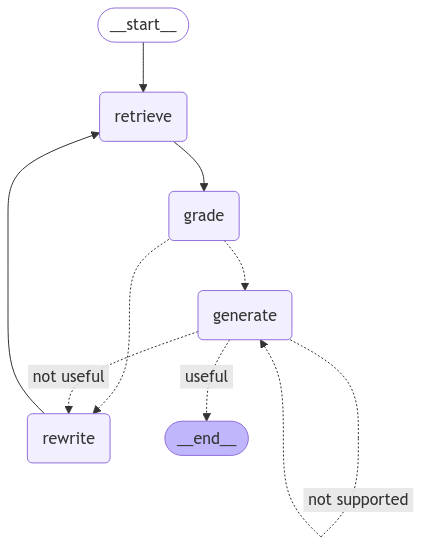

In [138]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

workflow = StateGraph(State)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade", grade)  # grade
workflow.add_node("generate", generate)  # generatae
workflow.add_node("rewrite", rewrite)  # rewrite

# Build graph
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade")

workflow.add_conditional_edges(
    "grade",
    decide_to_generate,
    {
        "rewrite": "rewrite",
        "generate": "generate",
    },
)

workflow.add_edge("rewrite", "retrieve")
workflow.add_conditional_edges(
    "generate",
    decide_to_answer,
    {
        "useful": END,
        "not useful": "rewrite",
        "not supported": "generate",
    },
)

# Compile
graph = workflow.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [139]:
import pprint

inputs = {"question": "Explain how the different types of agent memory work?"}
for output in graph.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint(value, indent=2, width=80, depth=None)

---RETRIEVE---
"Output from node 'retrieve':"
{ 'documents': [ Document(metadata={'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.\n\n\nMemory\n\nShort-term memory: I would consider 

In [105]:
import pprint

inputs = {"question": "Explain how chain of thought prompting works?"}
for output in graph.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint(value, indent=2, width=80, depth=None)

---RETRIEVE---
"Output from node 'retrieve':"
{ 'documents': [ Document(metadata={'description': 'Prompt Engineering, also known as In-Context Prompting, refers to methods for how to communicate with LLM to steer its behavior for desired outcomes without updating the model weights. It is an empirical science and the effect of prompt engineering methods can vary a lot among models, thus requiring heavy experimentation and heuristics.\nThis post only focuses on prompt engineering for autoregressive language models, so nothing with Cloze tests, image generation or multimodality models. At its core, the goal of prompt engineering is about alignment and model steerability. Check my previous post on controllable text generation.', 'language': 'en', 'source': 'https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/', 'title': "Prompt Engineering | Lil'Log"}, page_content='Use an iterative Monte Carlo search method to improve the best candidates by proposing semantically similar vari